In [1]:
import json
import re
from pathlib import Path
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

import analysishelper as ah
import cachedefs as cd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'mathtext.default':  'regular' })

# notes on data

we want to plot:
- for each app, the distribution of hot/startup/post from the cloud profile
    - also considering overlap
    - option A:
        - total number, stacked
        - potentially with total methods?
    - option B:
        - relative number
        - potentially of all methods?
- the overall distribution numbers of those
    - on average an app has XX methods, sd YY
    - on average an app has AA hot methods, sd BB

- finally, for the methods in the profiles, I want to know:
    - the distribution of package names

----
so we want 2 things:

| app name | number of methods | type |
| -------- | ----------------- | ---- |

where type is flags:
- hot = 1
- startup = 2
- poststartup = 4
- (0 for not niprovile at all)
- sums up nicely to total number of apps

but how do we get number of type 0?
total number of methods are in `../../../daily_apk_dm_analysis/all_profiles.json` 
we grab the profile methods and substract their sum from the total to get type 0 methods

nice. with that we can plot first two things




for the latter we'd need 

| app name | function signature |
| -------- | ------------------ |

we can get the full list from `apkanalyze dex packages base.apk`, but it does not have method ids, so either:
    - we calculate distribution independent
    - we only look at the profiles

for the longest package name:
```sh
cd $DIR/2025-05-007; 
ls | tr -d -c '.\n' | awk '{print length}' | sort
# ..
# 7
```

ugh. so, the profiles identify methods by dexid_methodid, but can this appear multiple times?
no, see https://stackoverflow.com/questions/32711272/android-gradle-exception-multiple-dex-files-define-duplicated-classes-under

In [2]:
# from 02_parse_and_collect.ipynb

def get_number_methods_by_type():
    with open(cd.CACHE_SAMPLE_PROFILES_JSON_PATH) as f:
        all_profile_data = json.load(f)

    dexcount_methods = pd.read_pickle(cd.CACHE_SAMPLE_DEXCOUNT)
    
    app_names = []
    hsp_list, hs_list, hp_list, sp_list, h_list, s_list, p_list, n_list = [],[], [], [], [], [], [], []

    for appid, profiles in tqdm.tqdm(all_profile_data.items()):
        if appid not in dexcount_methods.index:
            continue

        if "cloud" not in profiles.keys():
            continue
        primary = profiles["cloud"]

        kind_to_num_method = defaultdict(int)

        for _dexid, hotstartpost in primary.items():
            # we can ignore the dexid so we just see how many methods fall in each bucket and sum it up
            hot = set(hotstartpost.get('hot', []))
            start = set(hotstartpost.get('startup', []))
            post = set(hotstartpost.get('post', []))

            # methods in all three
            hsp = hot.intersection(start).intersection(post)
            kind_to_num_method[7] += len(hsp)

            hot.difference_update(hsp)
            start.difference_update(hsp)
            post.difference_update(hsp)

            #methods in two
            hs = hot.intersection(start)
            hp = hot.intersection(post)
            sp = start.intersection(post)

            kind_to_num_method[3] += len(hs)
            kind_to_num_method[5] += len(hp)
            kind_to_num_method[6] += len(sp)

            hot.difference_update(hs)  
            hot.difference_update(hp)
            post.difference_update(hp)
            post.difference_update(sp)
            start.difference_update(hs)
            start.difference_update(sp)

            # methods in only one kind
            kind_to_num_method[1] += len(hot)
            kind_to_num_method[2] += len(start)
            kind_to_num_method[4] += len(post)

        # grab total dex methods as outputted by apkanalyzer

        total = int(dexcount_methods.loc[appid].iloc[0])

        app_names.append(appid)
        notinprofile = total - sum(kind_to_num_method.values())
        assert(notinprofile >= 0) # if it's negative, its an error
        n_list.append(notinprofile)
        hsp_list.append(kind_to_num_method[7])
        hs_list.append(kind_to_num_method[3])
        hp_list.append(kind_to_num_method[5])
        sp_list.append(kind_to_num_method[6])
        h_list.append(kind_to_num_method[1])
        s_list.append(kind_to_num_method[2])
        p_list.append(kind_to_num_method[4])
        
    df = pd.DataFrame({
            'app id':app_names,
            'n':   n_list,
            'hsp': hsp_list,
            'hs':  hs_list,
            'hp':  hp_list,
            'sp':  sp_list,
            'h':   h_list,
            's':   s_list,
            'p':   p_list,
            
        })
    
    #df = df.astype({
    #        'app id': 'category',
    #        'kind': 'int8',
    #        'number of methods': 'uint32',
    #    })

    return df


df = get_number_methods_by_type()

            
                

    

100%|██████████| 844/844 [00:04<00:00, 195.55it/s]


In [3]:
df

,app id,n,hsp,hs,hp,sp,h,s,p
0,com.ForgeGames.SpecialForcesGroup2,89672,0,5917,0,0,0,7,0
1,com.bitstrips.imoji,175370,0,6391,0,0,0,1,0
2,com.callapp.contacts,429068,0,39807,0,0,39,154,0
3,com.playgendary.sportmasters,433320,0,15747,0,0,105,21763,0
4,cn.wps.moffice_eng,868021,0,25578,0,0,40,33,0
...,...,...,...,...,...,...,...,...,...
822,com.threed.bowling,24179,0,1977,0,0,0,0,0
823,com.google.android.deskclock,31536,0,6446,0,0,27,465,0
824,com.fundevs.app.mediaconverter,120560,0,8566,0,0,0,0,0
825,com.springwalk.mediaconverter,88010,0,11791,0,0,1,15,0


In [4]:
df.describe()

,n,hsp,hs,hp,sp,h,s,p
count,8.270000e+02,827.000000,827.000000,827.000000,827.0,827.000000,827.000000,827.000000
mean,2.623641e+05,19.243047,18511.923821,0.031439,0.0,247.663845,968.413543,0.315599
std,1.991474e+05,522.987278,14213.431544,0.869988,0.0,1099.354126,2855.023330,6.421686
min,8.820000e+02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.257800e+05,0.000000,7023.500000,0.000000,0.0,0.000000,0.000000,0.000000
50%,2.313110e+05,0.000000,15581.000000,0.000000,0.0,2.000000,21.000000,0.000000
75%,3.686275e+05,0.000000,28361.500000,0.000000,0.0,41.500000,374.000000,0.000000
max,1.942841e+06,15014.000000,89275.000000,25.000000,0.0,16282.000000,32771.000000,137.000000


In [5]:
# number of apps that have methods in these combinations
# hot_startup and only hot is very rare, hot_post more common
# no app has methods in only the hot or only the post categrory, all have methods share in hot_start_post
df.astype(bool).sum(axis=0)

app id    827
n         827
hsp         2
hs        825
hp          2
sp          0
h         478
s         557
p           2
dtype: int64

In [6]:
list(df.columns[1:])

['n', 'hsp', 'hs', 'hp', 'sp', 'h', 's', 'p']

In [7]:
stats = df.astype(bool).sum(axis=0)
stats['n']

np.int64(827)

In [8]:
from matplotlib import ticker

def plothotstartuppost(df, normalize=False):
    cols = list(['n', 'hsp', 'hs', 'hp', 'sp', 'h', 's', 'p']) # all but appid and sum
    stats = df.astype(bool).sum(axis=0)
    
    totals = df[cols].sum(axis=1)
    if normalize:
        df2 = df['app id']
        df2 = pd.concat([df['app id'], df[cols].divide(totals, axis='index')], axis=1)
        df2 = df2.sort_values(by=cols, ascending=False)
        fname = "cloud_profile_method_distribution_normalized"
    else:
        df2 = df
        df2['sum'] = totals
        df2 = df.sort_values(by=['sum', 'n', 'hsp', 'hs', 'hp', 'sp', 'h', 's', 'p'],ignore_index=True, ascending=False)
        df2 = df2[cols]
        fname = "cloud_profile_method_distribution"
    
    # remove 0s for faster plot
    df2 = df2.loc[~(df==0).all(axis=1)]
    ax = df2.plot.bar(stacked=True, figsize=(16,5),
                      color=[
                          "#66CCEE", # none
                          "#EE3377", # hsp
                          "#EE7733", # hs
                          "#4477AA", # hp
                          "#EE6677", # sp
                          "#DDAA33", # h
                          "#228833", # s
                          "#CC3311"  # p
                          ],
                      width=1.0)

    def mkfunc(x, pos): 
        return '%1.2fM' % (x * 1e-6) if x >= 1e6 else '%1.2fK' % (x * 1e-3) if x >= 1e3 else '%1.2f' % x
    
    ax.set_xticklabels([])
    #ax.ticklabel_format(style='plain', axis='y')
    mkformatter = ticker.FuncFormatter(mkfunc)
    ax.yaxis.set_major_formatter(mkformatter)

    ax.set_xlabel("Apps")
    ax.set_ylabel("Number of methods")
    ax.legend([
        "Methods of app not in cloud profile", 
        "Methods in cloud profile declared hot, startup, and post-startup (all apps)", 
        f"Methods in cloud profile declared hot and startup ({stats['hs']} apps)",
        f"Methods in cloud profile declared hot and post-startup ({stats['hp']} apps)",
        f"Methods in cloud profile declared startup and post-startup ({stats['sp']} apps)",
        f"Methods in cloud profile declared hot only ({stats['h']} apps)",
        f"Methods in cloud profile declared startup only ({stats['s']} apps)",
        f"Methods in cloud profile declared post-startup ({stats['p']} apps)",
        ])
    
    fig = ax.get_figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w, h*0.7)
    fig.savefig(f"{fname}.pdf", bbox_inches='tight')
    fig.savefig(f"{fname}.png", bbox_inches='tight')

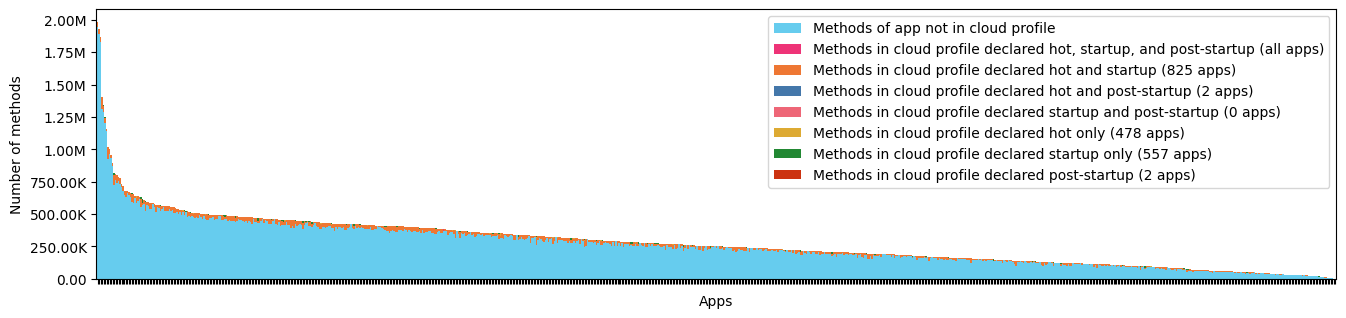

In [9]:
plothotstartuppost(df)

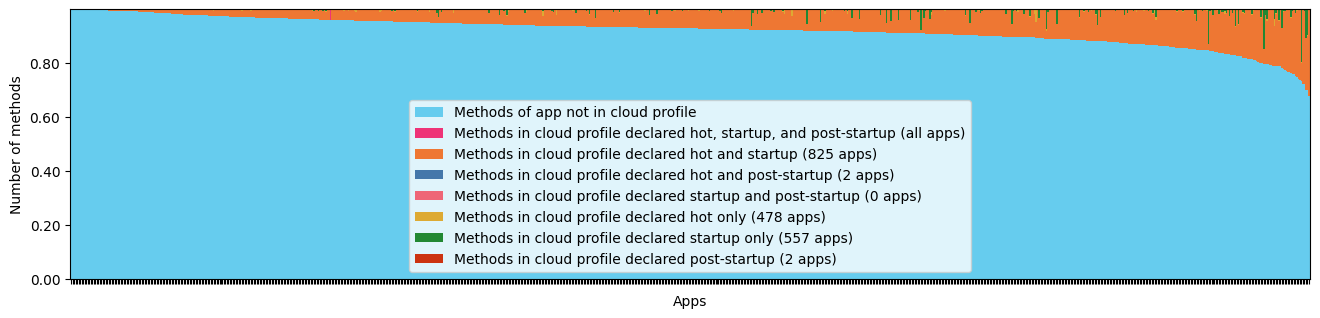

In [10]:
plothotstartuppost(df, normalize=True)

try out upsetplot

In [11]:
from upsetplot import from_memberships
from upsetplot import plot as uplot

In [25]:
example = from_memberships(
    [['0hot'],
     ['1startup'],
     ['2post'],
     ['0hot', '1startup'],
     ['0hot', '2post'],
     ['1startup', '2post'],
     ['0hot', '1startup', '2post']
     ],
     data=[827, 825, 2, 0, 478, 557, 2]
)
#example = example.reindex(columns=['hot', 'startup', 'post'])

/home/jakob/.pyenv/versions/3.11.5/envs/aot-profiles/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [26]:
example

0hot   1startup  2post
True   False     False    827
False  True      False    825
       False     True       2
True   True      False      0
       False     True     478
False  True      True     557
True   True      True       2
dtype: int64

/home/jakob/.pyenv/versions/3.11.5/envs/aot-profiles/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/jakob/.pyenv/versions/3.11.5/envs/aot-profiles/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interm

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: xlabel='Intersection size'>}

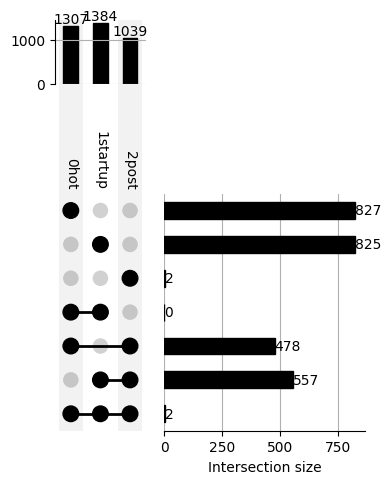

In [34]:
uplot(example, 
      #sort_by='input',
      sort_categories_by='input',
      subset_size='sum',
      orientation="vertical",
      show_counts=True)

# statistics cloud profiles
- we want:
  - overall avg + stdev for methods in apps
  - overall avg + stdev for methods in profiles
  - relative avg + stdev for methods in profiles per app methods

  so we need dataframe for 'app id', 'numm app', 'numm profile' and can calculate relative from that 

In [ ]:

def get_stats():
    with open(cd.CACHE_SAMPLE_PROFILES_JSON_PATH) as f:
        all_profile_data = json.load(f)

    dexcount_methods = pd.read_pickle(cd.CACHE_SAMPLE_DEXCOUNT)
    
    app_names = []
    numm_app = []
    numm_profile = []

    for appid, profiles in tqdm.tqdm(all_profile_data.items()):
        if appid not in dexcount_methods.index:
            continue

        if "cloud" not in profiles.keys():
            continue
        primary = profiles["cloud"]

        unique_profile = 0

        for _dexid, hotstartpost in primary.items():
            # per dex id we put all in a set and sum it up at the end

            # we can ignore the dexid so we just see how many methods fall in each bucket and sum it up
            hot = set(hotstartpost.get('hot', []))
            start = set(hotstartpost.get('startup', []))
            post = set(hotstartpost.get('post', []))

            unique_profile += len(hot.union(start).union(post))

        # grab total dex methods as outputted by apkanalyzer

        total = int(dexcount_methods.loc[appid].iloc[0])

        app_names.append(appid)
        numm_app.append(total)
        numm_profile.append(unique_profile)
        
    df = pd.DataFrame({
            'app id':app_names,
            'numm app':   numm_app,
            'numm profile': numm_profile,
        })
    

    return df


df = get_stats()

100%|██████████| 844/844 [00:01<00:00, 485.77it/s]


In [ ]:

df['relative'] = df['numm profile']*100 / df['numm app']

In [ ]:

df.describe().round(2)

,numm app,numm profile,relative
count,827.00,827.00,827.00
mean,282111.65,19747.59,7.88
std,208079.71,15131.20,5.17
min,973.00,44.00,0.04
25%,134478.50,7449.00,4.40
50%,250628.00,16821.00,7.11
75%,401721.00,30555.00,10.06
max,1982841.00,96153.00,32.31


In [ ]:
df[df['app id'] == 'org.thoughtcrime.securesms']

,app id,numm app,numm profile,relative
468,org.thoughtcrime.securesms,307076,56774,18.488583
